# PyTorch Experiment Tracking

In [1]:
import torch
import torchvision

print( torch.__version__)
print( torchvision.__version__)

2.2.2+cu121
0.17.2+cu121


In [2]:
from datetime import datetime
import os
import matplotlib.pyplot as plt
from torchinfo import summary
from modules import data_setup, engine

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [4]:
def set_seeds( seed: int = 42):
	"""Sets random sets for torch operations.

	Args:
		seed (int, optional): Random seed to set, Defaults to 42
	"""

	torch.manual_seed( seed)
	torch.cuda.manual_seed( seed)

## 1. Get data

In [5]:
import os
import zipfile

from pathlib import Path

import requests

def download_data( source: str,
				   destination: str,
				   remove_source: bool = True) -> Path:
	"""Download a zipped dataset from source and unzip to destination."""

	data_path = Path( "data/")
	image_path = data_path / destination

	if image_path.is_dir():
		print( f"[INFO] { image_path} directory already exists, skipping download.")
	else:
		print( f"[INFO] Did not find { image_path} directory, creating one...")
		image_path.mkdir( parents=True, exist_ok=True)

		target_file = Path( source).name
		with open( data_path / target_file, "wb") as f:
			print( f"[INFO] Downloading { target_file} from { source}...")
			request = requests.get( source)
			f.write( request.content)

		with zipfile.ZipFile( data_path / target_file, "r") as zip_ref:
			print( f"[INFO] Unzipping { target_file} data...")
			zip_ref.extractall( image_path)

		if remove_source:
			os.remove( data_path / target_file)

	return image_path

In [ ]:
image_path = download_data( source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
			   				destination="pizza_steak_sushi")

## 2. Create Datasets and DataLoaders

### 2.1 Create DataLoaders with manual transforms

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

In [ ]:
# Setup ImageNet normalization levels
from torchvision import transforms

normalize = transforms.Normalize( mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose( [
	transforms.Resize( ( 224, 224)),
	transforms.ToTensor(),
	normalize
])

print( f"Manually created transforms: { manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders( train_dir,
																			    test_dir,
																				transform=manual_transforms,
																				batch_size=32)

train_dataloader, test_dataloader, class_names

### 2.2 Create DataLoaders using automatically created transforms

In [ ]:
from torchvision.models import EfficientNet_B0_Weights

weights = EfficientNet_B0_Weights.DEFAULT

auto_transforms = weights.transforms()

print( f"Automatically created transforms: { auto_transforms}")

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders( train_dir,
																			    test_dir,
																				transform=auto_transforms,
																				batch_size=32)

train_dataloader, test_dataloader, class_names

## 3. Getting a pretrained model, freeze base layers and change classifier head

In [ ]:
# Old method prior to torchvision v0.13
# model = torchvision.models.efficientnet_b0( pretrained=True).to( device) 

# Download the pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup the model with the pretrained weights
model = torchvision.models.efficientnet_b0( weights=weights).to( device)

In [ ]:
# Freeze all base layers by setting their require_grad attribute to False
for param in model.features.parameters():
	param.requires_grad = False

In [ ]:
# Change the classifier head

model.classifier = torch.nn.Sequential(
	torch.nn.Dropout( p=0.2, inplace=True),
	torch.nn.Linear( in_features=1280, out_features=len( class_names))
).to( device)

In [ ]:
summary( model,
		 input_size=( 32, 3, 224, 224),
		 verbose=0,
		 col_names=[ "input_size", "output_size", "num_params", "trainable"],
		 col_width=20,
		 row_settings=[ "var_names"])

## 4. Train a single model and track results

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( params=model.parameters(), lr=0.001)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter( log_dir="experiments")
writer

In [16]:
from typing import Dict, List
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

def train( model: torch.nn.Module, 
           train_dataloader: torch.utils.data.DataLoader, 
           test_dataloader: torch.utils.data.DataLoader, 
           optimizer: torch.optim.Optimizer,
           loss_fn: torch.nn.Module,
           epochs: int,
           device: torch.device,
           writer: SummaryWriter = None) -> Dict[ str, List[ float]]:
  
  	# Create empty results dictionary
	results = {
		"train_loss": [],
		"train_acc": [],
		"test_loss": [],
		"test_acc": []
	}
  
	# Loop through training and testing steps for a number of epochs
	for epoch in tqdm( range( epochs)):
		train_loss, train_acc = engine.train_step( model=model,
													dataloader=train_dataloader,
													loss_fn=loss_fn,
													optimizer=optimizer,
													device=device)
		test_loss, test_acc = engine.test_step( model=model,
												dataloader=test_dataloader,
												loss_fn=loss_fn,
												device=device)
		
		# Print out what's happening
		print(
			f"Epoch: { epoch + 1} | "
			f"train_loss: { train_loss:.4f} | "
			f"train_acc: { train_acc:.4f} | "
			f"test_loss: { test_loss:.4f} | "
			f"test_acc: { test_acc:.4f}"
		)

		# Update results dictionary
		results[ "train_loss"].append( train_loss)
		results[ "train_acc"].append( train_acc)
		results[ "test_loss"].append( test_loss)
		results[ "test_acc"].append( test_acc)
      
	  	### New: Experiment tracking ###
		if writer:
			writer.add_scalars( main_tag="Loss",
								tag_scalar_dict={ "train_loss": train_loss,
												"test_loss": test_loss},
								global_step=epoch)
			
			writer.add_scalars( main_tag="Accuracy",
								tag_scalar_dict={ "train_acc": train_acc,
												"test_acc": test_acc},
								global_step=epoch)
			
			writer.add_graph( model=model,
							input_to_model=torch.randn( 32, 3, 224, 224).to( device))

			# Close the writer
			writer.close()
			### End New ###

	# Return the filled results at the end of the epochs
	return results


In [ ]:
set_seeds()

results = train( model,
				 train_dataloader,
				 test_dataloader,
				 optimizer,
				 loss_fn,
				 epochs=5,
				 device=device,
				 writer=writer)

## 5. View TensorBoard in VS Code

Press `CTRL + SHIFT + P` to open the Command Palette and searcg for the command "Python: Launch TensorBoard"

## 6. Create a function to prepare a `SummaryWriter()` instance

In [6]:
def create_writer( experiment_name: str,
				   model_name: str,
				   extra: str = None):
	
	timestamp = datetime.now().strftime( "%Y-%m-%d")

	if extra:
		log_dir = os.path.join( "experiments", timestamp, experiment_name, model_name, extra)
	else:
		log_dir = os.path.join( "experiments", timestamp, experiment_name, model_name)

	print( f"[INFO] Created SummaryWriter saving to { log_dir}")

	return SummaryWriter( log_dir)


## 7. Setting up a series of modelling experiments

1. Model size - EffnetB0 vs EffnetB2
2. Dataset site - 10& of pizza, steak, sushi images vs 20%
3. Training time - 5 epochs vs 10 epochs

### 7.1 Download different datasets

1. Pizza, steak, sushi 10% - [Download Link](https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip)
2. Pizza, steak, sushi 20% - [Download Link](https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip)

In [7]:
# Download 10 percent
data_10_percent_path = download_data( source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
									  destination="pizza_steak_sushi")

data_20_percent_path = download_data( source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip",
									  destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory already exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory already exists, skipping download.


### 7.2 Transform Datasets and Create DataLoaders

1. Resize the images to (224, 224)
2. Make sure image tensors are between [0,1]
3. Normalize the images so they have the same data distribution as ImageNet

In [8]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup test directory path
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [9]:
from torchvision import transforms

normalize = transforms.Normalize( mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

simple_transforms = transforms.Compose( [ transforms.Resize( ( 224, 224)),
										  transforms.ToTensor(),
										  normalize])

In [10]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders( train_dir=train_dir_10_percent,
																						   test_dir=test_dir,
																						   transform=simple_transforms,
																						   batch_size=BATCH_SIZE)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders( train_dir=train_dir_20_percent,
																						   test_dir=test_dir,
																						   transform=simple_transforms,
																						   batch_size=BATCH_SIZE)

print( f"Number of batches of size { BATCH_SIZE} in 10% train data: { len( train_dataloader_10_percent)}")
print( f"Number of batches of size { BATCH_SIZE} in 20% train data: { len( train_dataloader_20_percent)}")
print( f"Number of batches of size { BATCH_SIZE} in 10% test data: { len( test_dataloader)}")
print( f"Class Names: { class_names}")

Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 20% train data: 15
Number of batches of size 32 in 10% test data: 3
Class Names: ['pizza', 'steak', 'sushi']


### 7.3 Create feature extractor models

1. Creates a `torchvision.models.efficientnet_b0()` feature extractor with a frozen backbone/base layers and a custom classifier head (EffNetB0).
2. Creates a `torchvision.models.efficientnet_b2()` feature extractor with a frozen backbone/base layers and a custom classifier head (EffNetB2).

In [18]:
import torchvision

# Create and EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2( weights=effnetb2_weights)

summary( model=effnetb2,
		 input_size=( 32, 3, 224, 224),
		 verbose=0,
		 col_names=[ "input_size", "output_size", "num_params", "trainable"],
		 col_width=20,
		 row_settings=[ "var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [11]:
import torchvision
from torch import nn

OUT_FEATURES = len( class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
	# Get weights and setup a model
	weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
	model = torchvision.models.efficientnet_b0( weights=weights).to( device)

	# Freeze the base model layers
	for param in model.features.parameters():
		param.requires_grad = False

	set_seeds()
	model.classifier = nn.Sequential(
		nn.Dropout( p=0.2, inplace=True),
		nn.Linear( in_features=1280, out_features=OUT_FEATURES)
	).to( device)

	# Give the model a name
	model.name = "effnetb0"
	print( f"[INFO] Created new { model.name} model...")

	return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
	# Get weights and setup a model
	weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
	model = torchvision.models.efficientnet_b2( weights=weights).to( device)

	# Freeze the base model layers
	for param in model.features.parameters():
		param.requires_grad = False

	set_seeds()
	model.classifier = nn.Sequential(
		nn.Dropout( p=0.3, inplace=True),
		nn.Linear( in_features=1408, out_features=OUT_FEATURES)
	).to( device)

	# Give the model a name
	model.name = "effnetb2"
	print( f"[INFO] Created new { model.name} model...")

	return model

### 7.4 Create experiments and setup training code

In [13]:
# Create epoch list
num_epochs = [ 5, 10]

# Create models list 
models = [ "effnetb0", "effnetb2"]

# Create a DataLoaders dictionary
train_dataloaders = { "data_10_percent": train_dataloader_10_percent,
					  "data_20_percent": train_dataloader_20_percent}

In [17]:
from modules.utils import save_model

# Set seeds
set_seeds()

# Kepp track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
	# Loop through the epochs:
	for epochs in num_epochs:
		# Loop through each model name and create a new model instance
		for model_name in models:
			
			# Print out info
			experiment_number += 1
			print( f"[INFO] Experiment number: { experiment_number}")
			print( f"[INFO] Model: { model_name}")
			print( f"[INFO] DataLoader: { dataloader_name}")
			print( f"[INFO] Number of epochs: { epochs}")

			# Select and create the model
			if model_name == "effnetb0":
				model = create_effnetb0()
			else:
				model = create_effnetb2()

			# Create a new loss and optimizer
			loss_fn = nn.CrossEntropyLoss()
			optimizer = torch.optim.Adam( params=model.parameters(), lr=0.001)

			# Train target model with target dataloader and track experiment

			writer = create_writer( experiment_name=dataloader_name,
									model_name=model_name,
									extra=f"{ epochs}_epochs")

			train( model=model,
		 		   train_dataloader=train_dataloader,
				   test_dataloader=test_dataloader,
				   optimizer=optimizer,
				   loss_fn=loss_fn,
				   epochs=epochs,
				   device=device,
				   writer=writer)
			
			# Save the model to file
			save_filepath = f"08_{ model_name}_{ dataloader_name}_{ epochs}_epochs.pth"
			save_model( model=model,
			  			target_dir="models",
						model_name=save_filepath)
			
			print( "-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to experiments\2025-09-01\data_10_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0419 | train_acc: 0.5078 | test_loss: 0.9291 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.9355 | train_acc: 0.5391 | test_loss: 0.8389 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.8194 | train_acc: 0.6992 | test_loss: 0.7309 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7081 | train_acc: 0.7578 | test_loss: 0.6198 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6103 | train_acc: 0.8984 | test_loss: 0.5847 | test_acc: 0.8864
[INFO] Saving model to: models\08_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to experiments\2025-09-01\data_10_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0996 | train_acc: 0.3789 | test_loss: 0.9582 | test_acc: 0.7008
Epoch: 2 | train_loss: 0.8932 | train_acc: 0.6562 | test_loss: 0.9010 | test_acc: 0.6818
Epoch: 3 | train_loss: 0.8518 | train_acc: 0.6797 | test_loss: 0.8037 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7056 | train_acc: 0.8438 | test_loss: 0.6933 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.7087 | train_acc: 0.7266 | test_loss: 0.6512 | test_acc: 0.8968
[INFO] Saving model to: models\08_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to experiments\2025-09-01\data_10_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0419 | train_acc: 0.5078 | test_loss: 0.9291 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.9355 | train_acc: 0.5391 | test_loss: 0.8389 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.8194 | train_acc: 0.6992 | test_loss: 0.7309 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7081 | train_acc: 0.7578 | test_loss: 0.6198 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6103 | train_acc: 0.8984 | test_loss: 0.5847 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5421 | train_acc: 0.8633 | test_loss: 0.5978 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.6381 | train_acc: 0.7148 | test_loss: 0.5968 | test_acc: 0.8049
Epoch: 8 | train_loss: 0.5144 | train_acc: 0.7969 | test_loss: 0.5417 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4703 | train_acc: 0.9141 | test_loss: 0.5348 | test_acc: 0.8759
Epoch: 10 | train_loss: 0.5766 | train_acc: 0.7422 | test_loss: 0.4893 | test_acc: 0.8759
[INFO] Saving model to: models\08_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0996 | train_acc: 0.3789 | test_loss: 0.9582 | test_acc: 0.7008
Epoch: 2 | train_loss: 0.8932 | train_acc: 0.6562 | test_loss: 0.9010 | test_acc: 0.6818
Epoch: 3 | train_loss: 0.8518 | train_acc: 0.6797 | test_loss: 0.8037 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7056 | train_acc: 0.8438 | test_loss: 0.6933 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.7087 | train_acc: 0.7266 | test_loss: 0.6512 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5930 | train_acc: 0.8984 | test_loss: 0.6588 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.6169 | train_acc: 0.8047 | test_loss: 0.6052 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.5379 | train_acc: 0.8242 | test_loss: 0.6010 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.5009 | train_acc: 0.9102 | test_loss: 0.5594 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.5176 | train_acc: 0.7930 | test_loss: 0.5439 | test_acc: 0.9384
[INFO] Saving model to: models\08_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9642 | train_acc: 0.6062 | test_loss: 0.6642 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.6942 | train_acc: 0.7833 | test_loss: 0.5802 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5825 | train_acc: 0.8354 | test_loss: 0.5006 | test_acc: 0.8873
Epoch: 4 | train_loss: 0.4569 | train_acc: 0.8938 | test_loss: 0.4167 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4512 | train_acc: 0.8646 | test_loss: 0.3828 | test_acc: 0.9280
[INFO] Saving model to: models\08_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to experiments\2025-09-01\data_20_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9874 | train_acc: 0.5188 | test_loss: 0.7843 | test_acc: 0.7945
Epoch: 2 | train_loss: 0.7165 | train_acc: 0.8104 | test_loss: 0.6552 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8958 | test_loss: 0.5589 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5155 | train_acc: 0.8542 | test_loss: 0.5124 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4698 | train_acc: 0.8583 | test_loss: 0.4482 | test_acc: 0.9489
[INFO] Saving model to: models\08_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to experiments\2025-09-01\data_20_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9642 | train_acc: 0.6062 | test_loss: 0.6642 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.6942 | train_acc: 0.7833 | test_loss: 0.5802 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5825 | train_acc: 0.8354 | test_loss: 0.5006 | test_acc: 0.8873
Epoch: 4 | train_loss: 0.4569 | train_acc: 0.8938 | test_loss: 0.4167 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4512 | train_acc: 0.8646 | test_loss: 0.3828 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4179 | train_acc: 0.8958 | test_loss: 0.3720 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.4001 | train_acc: 0.8625 | test_loss: 0.3399 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3389 | train_acc: 0.8958 | test_loss: 0.3502 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3732 | train_acc: 0.8958 | test_loss: 0.3430 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3823 | train_acc: 0.8875 | test_loss: 0.2847 | test_acc: 0.9176
[INFO] Saving model to: models\08_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9874 | train_acc: 0.5188 | test_loss: 0.7843 | test_acc: 0.7945
Epoch: 2 | train_loss: 0.7165 | train_acc: 0.8104 | test_loss: 0.6552 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8958 | test_loss: 0.5589 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5155 | train_acc: 0.8542 | test_loss: 0.5124 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4698 | train_acc: 0.8583 | test_loss: 0.4482 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3840 | train_acc: 0.9083 | test_loss: 0.4633 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3613 | train_acc: 0.8896 | test_loss: 0.4198 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3275 | train_acc: 0.9021 | test_loss: 0.4182 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.3488 | train_acc: 0.8938 | test_loss: 0.4370 | test_acc: 0.8674
Epoch: 10 | train_loss: 0.3729 | train_acc: 0.8667 | test_loss: 0.3765 | test_acc: 0.9489
[INFO] Saving model to: models\08_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

## 8. View experiments in TensorBoard

The best performing model in terms of test accuracy:
* Model: EffNetB2
* Dataset: Pizza, steak, sushi 20%
* Epochs: 10

The best performing model in terms of test loss:
* Model: EffNetB0
* Dataset: Pizza, steak, sushi 20%
* Epochs: 10

the overall trend of all the results was that more dta, bigger model and longer training time generally lead to better results

## 9. Load in the best model

path to best model: `models/08_effnetb2_data_20_percent_10_epochs.pth`

In [18]:
# Setup best model filepath
best_model_path = "models/08_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load in the save state_dict())
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict( torch.load( best_model_path))

[INFO] Created new effnetb2 model...


<All keys matched successfully>

In [19]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert it to megabytes
effnetb2_model_size = Path( best_model_path).stat().st_size // ( 1024 * 1024)
print( f"EfficientNetB2 feature extractor model size: { effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


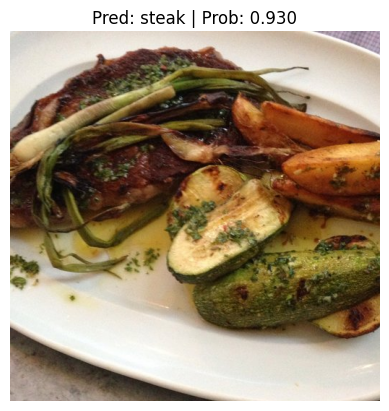

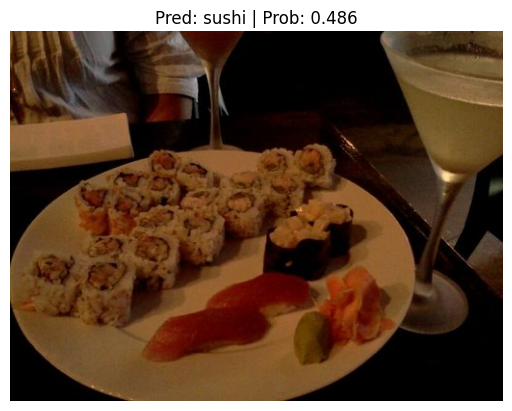

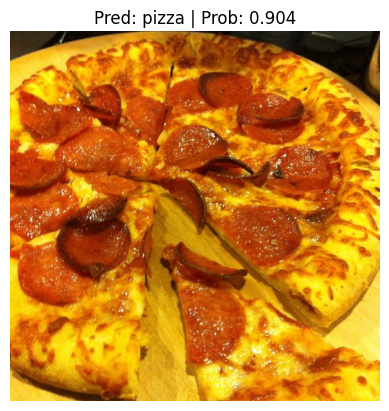

In [21]:
# Import function to make prediction on images and plot them
from modules.predictions import pred_and_plot_image

# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot = 3
test_image_path_list = list( Path( data_20_percent_path / "test").glob( "*/*.jpg"))
test_image_path_sample = random.sample( test_image_path_list, k=num_images_to_plot)

for image_path in test_image_path_sample:
	pred_and_plot_image( model=best_model,
						 image_path=image_path,
						 class_names=class_names,
						 image_size=( 224, 224))